In [1]:
from firedrake import *
from pyroteus import *
from pyroteus_adjoint import *
import matplotlib.pyplot as plt
from movement import *
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'  # Ensure  background on plots is white

NU = 0.0001


def get_form(mesh_seq):
    def form(index, solutions):
        u, u_ = solutions["u"]
        P = mesh_seq.time_partition
        dt = Constant(P.timesteps[index])
        nu = Constant(NU)

        v = TestFunction(u.function_space())
        F = (
            inner((u - u_) / dt, v) * dx
            + inner(dot(u, nabla_grad(u)), v) * dx
            + nu * inner(grad(u), grad(v)) * dx
        )
        return F

    return form


def get_solver(mesh_seq):
    def solver(index, ic):
        function_space = mesh_seq.function_spaces["u"][index]
        u = Function(function_space)

        u_ = Function(function_space, name="u_old")
        u_.assign(ic["u"])

        # Define form
        F = mesh_seq.form(index, {"u": (u, u_)})

        # Time integrate from start to end
        P = mesh_seq.time_partition
        t_start, t_end = P.subintervals[index]
        dt = P.timesteps[index]
        t = t_start
        while t < t_end - 1e-5:
            solve(F == 0, u, ad_block_tag="u")
            u_.assign(u)
            t += dt
        return {"u": u}

    return solver


def get_function_spaces(mesh):
    return {"u": VectorFunctionSpace(mesh, "CG", 1), "f": FunctionSpace(mesh, "DG", 0)}


def get_initial_condition(mesh_seq):
    fs = mesh_seq.function_spaces["u"][0]
    x, y = SpatialCoordinate(mesh_seq[0])
    # An initial condition that propagates to both ends
    return {"u": interpolate(as_vector([sin(pi * (x - 0.5)), 0]), fs)}


def get_qoi(mesh_seq, solutions, i):
    def end_time_qoi():
        u = solutions["u"]
        # ds(2) is dy (ds, subdomain 2)
        return inner(u, u) * ds(2)

    return end_time_qoi

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
n = 16
fields = ["u"]
mesh = UnitSquareMesh(n, n, diagonal='left')
# We use a pyroteus.MeshSeq even though we have only one mesh because it allows us to use MeshSeq.indicate_errors()
meshes = [mesh]
end_time = 0.5
dt = 1 / n
num_subintervals = len(meshes)
time_partition = TimePartition(
    end_time, num_subintervals, dt, fields, timesteps_per_export=1
)
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="end_time",
)
solutions, indicators = mesh_seq.indicate_errors(
    enrichment_kwargs={"enrichment_method": "p"}
)

4 2


Text(0.5, 1.0, 'DWR Error indicators')

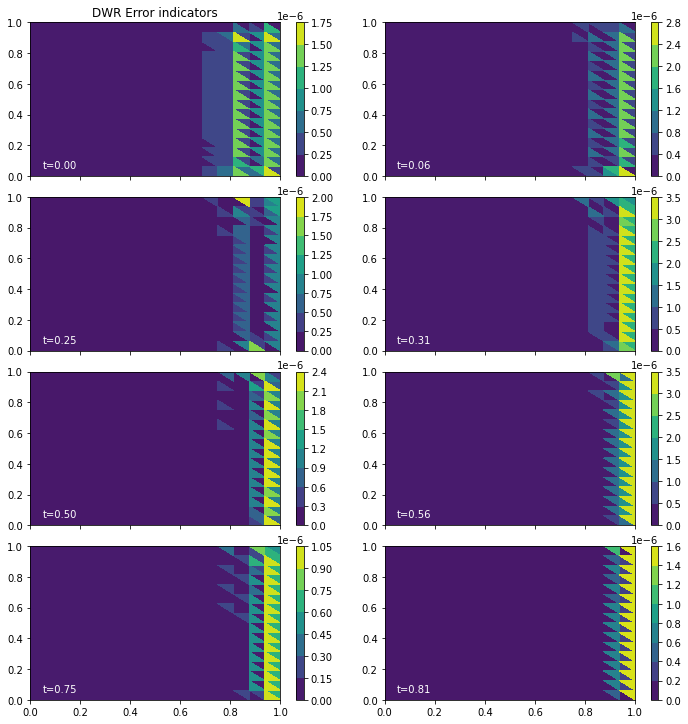

In [3]:
def plot_indicators(indicators, time_partition, **kwargs):
    """
    Plot a sequence of snapshots associated with
    ``indicators`` and :class:`TimePartition`
    ``time_partition``.

    Any keyword arguments are passed to ``tricontourf``.

    :arg indicators: list of list of indicators,
        indexed by mesh sequence index, then timestep
    :arg time_partition: the :class:`TimePartition`
        object used to solve the problem
    """
    P = time_partition
    rows = (P.exports_per_subinterval[0] - 1) // 2
    cols = P.num_subintervals * 2
    steady = rows == cols == 1
    print(rows, cols)
    figsize = kwargs.pop("figsize", (6 * cols, 24 // cols))
    fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
    tcs = []
    idx = -1
    for i in range(rows):
        tc = []
        for j in range(cols):
            idx += 1
            ax = axes[i, j]
            # Element-wise norm for the indicators
            tc.append(tricontourf(indicators[0][idx], axes=ax, **kwargs))
            if not steady:
                time = i * P.end_time/cols + j * P.timesteps_per_export[0] * P.timesteps[0]
                ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="white")
        tcs.append(tc)
    plt.tight_layout()
    return fig, axes, tcs


figsize = (10, 10)
fig, axs, tcs = plot_indicators(indicators, time_partition, figsize=figsize)
# print(len(axs), len(tcs), len(tcs[0]))
for i in range(len(axs)):
    for j in range(len(axs[0])):
        fig.colorbar(tcs[i][j], ax=axs[i,j])
axs[0, 0].set_title("DWR Error indicators")
# axs.reshape((2, 2))

4 2


Text(0.5, 1.0, 'log DWR Errors')

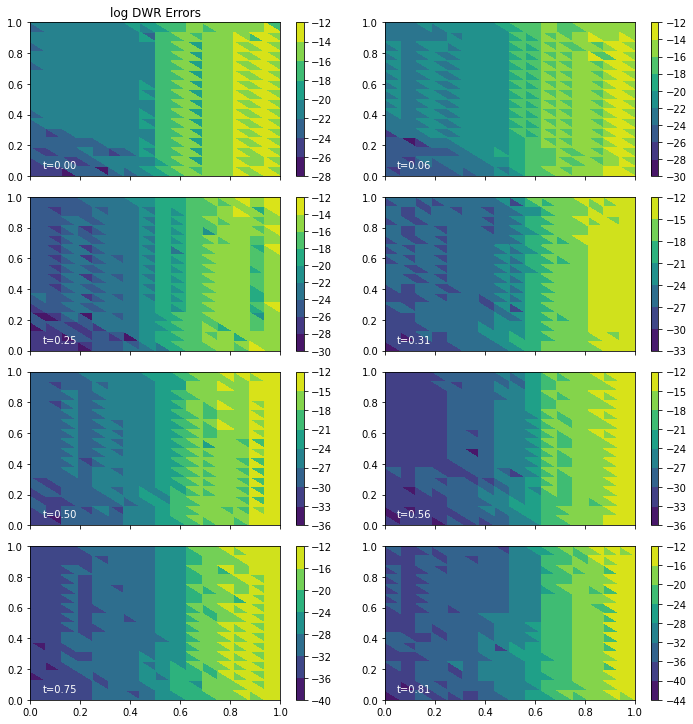

In [5]:
P0 = indicators[0][0].function_space()
log_indicators = [[Function(P0, val=np.log(indicators[0][i].dat.data)) for i in range(len(indicators[0]))]]
fig, axs, tcs = plot_indicators(log_indicators, time_partition, figsize=figsize)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        fig.colorbar(tcs[i][j], ax=axs[i, j])
axs[0][0].set_title("log DWR Errors")

## Using max() to make monitor function time-independent

In [5]:
P0 = indicators[0][0].function_space()
monitor_fns = []
areas = [get_areas2d(mesh) for mesh in mesh_seq]
vmax, vmin = -np.inf, np.inf
for i, mesh_i in enumerate(indicators):
    area = areas[i]
    
    max_errs = np.zeros(indicators[i][0].dat.data.shape)
    for j, e_t in enumerate(indicators[i]):
        max_errs = np.maximum(max_errs, e_t.dat.data)
        
    vmax = np.max((vmax, np.max(max_errs)))
    vmin = np.min((vmin, np.min(max_errs)))
    print(np.max(max_errs), np.min(max_errs))
#     print(max_errs)
#     print(1/max_errs)
    monitor_fn = Function(P0, val=max_errs)
    monitor_fns.append([monitor_fn])
print(len(monitor_fns), len(monitor_fns[0]))

3.47533812209708e-06 9.116917087212612e-12
1 1


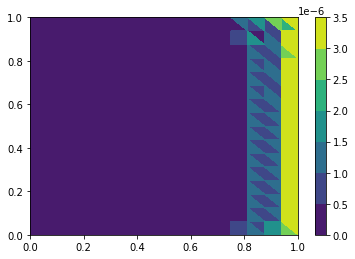

In [6]:
tc = tricontourf(monitor_fns[0][0])
plt.colorbar(tc)

In [7]:
def normalize(arr):
    normed = (arr - np.mean(arr)) / np.std(arr)
    normed -= np.min(normed)
    normed += 1
    return normed

monitor_fn = Function(P0, val=normalize(monitor_fns[0][0].dat.data))

1.0 5.262365118601104


Text(0.5, 1.0, 'Normalized (Max) Monitor function')

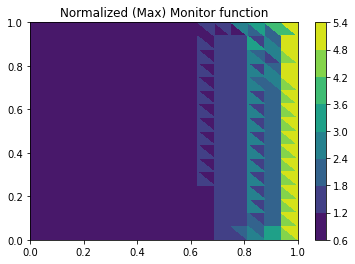

In [8]:
print(np.min(monitor_fn.dat.data), np.max(monitor_fn.dat.data))
tc = tricontourf(monitor_fn)
plt.colorbar(tc)
plt.title("Normalized (Max) Monitor function")

In [11]:
def get_monitor(mesh):
    P0 = FunctionSpace(mesh, "DG", 0)
    f = Function(P0)
    f.project(monitor_fn)
    return f

# print(mesh)
mover = MongeAmpereMover(mesh, get_monitor, method="quasi_newton", maxiter=100, rtol=1e-7)
mover.move();

   0   Min/Max 1.9443e-01   Residual 3.2418e-01   Equidistribution 9.8998e-01
   1   Min/Max 3.6985e-03   Residual 1.7156e-02   Equidistribution 9.9585e-01
   2   Min/Max 1.8346e-02   Residual 1.8953e-04   Equidistribution 9.9581e-01
   3   Min/Max 1.6543e-02   Residual 1.3869e-06   Equidistribution 9.9580e-01
   4   Min/Max 1.6541e-02   Residual 1.0559e-10   Equidistribution 9.9580e-01
Converged in 4 iterations.


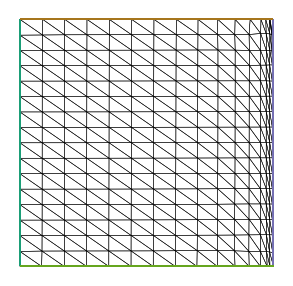

In [12]:
def plot_mesh(mesh, fig=None, axes=None, **kwargs):
    kwargs.setdefault("interior_kw", {"linewidth": 0.5})
    kwargs.setdefault("boundary_kw", {"linewidth": 2.0})
    if fig is None and axes is None:
        fig, axes = plt.subplots(figsize=(5, 5))
    tp = triplot(mesh, axes=axes, **kwargs)
    axes.axis(False)
    return fig, axes, tp

plot_mesh(mesh);

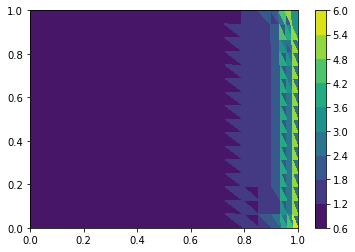

In [10]:
tc = tricontourf(monitor_fn)
plt.colorbar(tc)

Text(0.5, 1.0, 'Adapted by (Max) Monitor function')

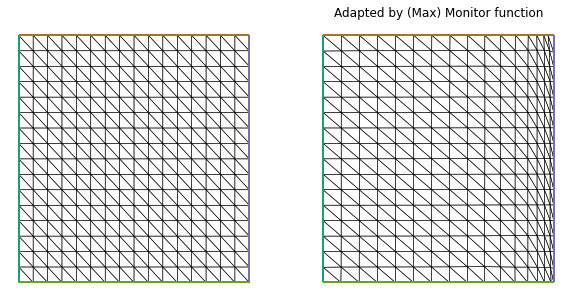

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
unadapted_mesh = UnitSquareMesh(n, n, diagonal='left')

fig, axs[0], tp = plot_mesh(unadapted_mesh, fig=fig, axes=axs[0])
fig, axs[1], tp = plot_mesh(mesh, fig=fig, axes=axs[1])
axs[1].set_title("Adapted by (Max) Monitor function")

## Using average to make monitor function time-independent

In [42]:
P0 = indicators[0][0].function_space()
monitor_fns = []
for i, mesh_i in enumerate(indicators):
    max_errs = np.zeros(indicators[i][0].dat.data.shape)
    avg_errs = np.zeros(indicators[i][0].dat.data.shape)
    for j, e_t in enumerate(indicators[i]):
        max_errs = np.maximum(max_errs, e_t.dat.data)
        avg_errs += e_t.dat.data

    monitor_fn = Function(P0, val=avg_errs / len(indicators[i]))
    monitor_fns.append([monitor_fn])

1.0 5.569100866503456


Text(0.5, 1.0, '(Avg) Monitor function')

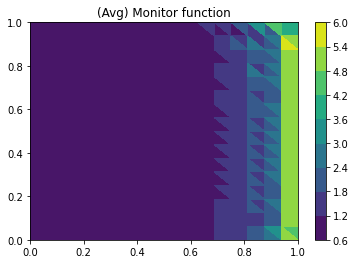

In [43]:
monitor_fn = Function(P0, val=normalize(monitor_fns[0][0].dat.data))
print(np.min(monitor_fn.dat.data), np.max(monitor_fn.dat.data))
tc = tricontourf(monitor_fn)
plt.colorbar(tc)
plt.title("(Avg) Monitor function")

In [44]:
def get_monitor(mesh):
    P0 = FunctionSpace(mesh, "DG", 0)
    f = Function(P0)
    f.project(monitor_fn)
    return f

# print(mesh)
mover = MongeAmpereMover(mesh, get_monitor, method="quasi_newton", maxiter=100, rtol=1e-6)
mover.move();

   0   Min/Max 1.9360e-01   Residual 6.5014e-01   Equidistribution 9.8994e-01
   1   Min/Max 5.0058e-01   Residual 1.5088e-02   Equidistribution 9.9682e-01
   2   Min/Max 4.0205e-01   Residual 8.6171e-04   Equidistribution 9.9627e-01
   3   Min/Max 4.0611e-01   Residual 4.7913e-06   Equidistribution 9.9633e-01
Converged in 3 iterations.


Text(0.5, 1.0, 'Adapted by (Avg) Monitor function')

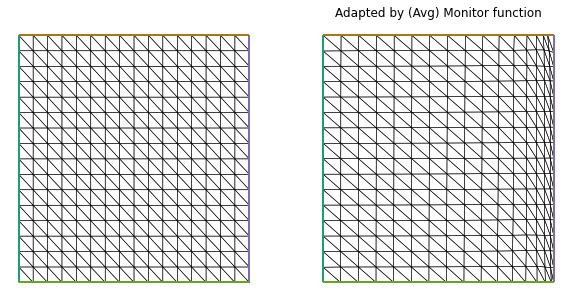

In [45]:
def plot_mesh(mesh, fig=None, axes=None, **kwargs):
    kwargs.setdefault("interior_kw", {"linewidth": 0.5})
    kwargs.setdefault("boundary_kw", {"linewidth": 2.0})
    if fig is None and axes is None:
        fig, axes = plt.subplots(figsize=(5, 5))
    tp = triplot(mesh, axes=axes, **kwargs)
    axes.axis(False)
    return fig, axes, tp

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
unadapted_mesh = UnitSquareMesh(n, n, diagonal='left')

fig, axs[0], tp = plot_mesh(unadapted_mesh, fig=fig, axes=axs[0])
fig, axs[1], tp = plot_mesh(mesh, fig=fig, axes=axs[1])
axs[1].set_title("Adapted by (Avg) Monitor function")

# Validating that the magnitude of errors has gone down on the new mesh

In [46]:
solutions, indicators = mesh_seq.indicate_errors(
    enrichment_kwargs={"enrichment_method": "p"}
)

4 2
4 4 2


Text(0.5, 1.0, 'new DWR errors')

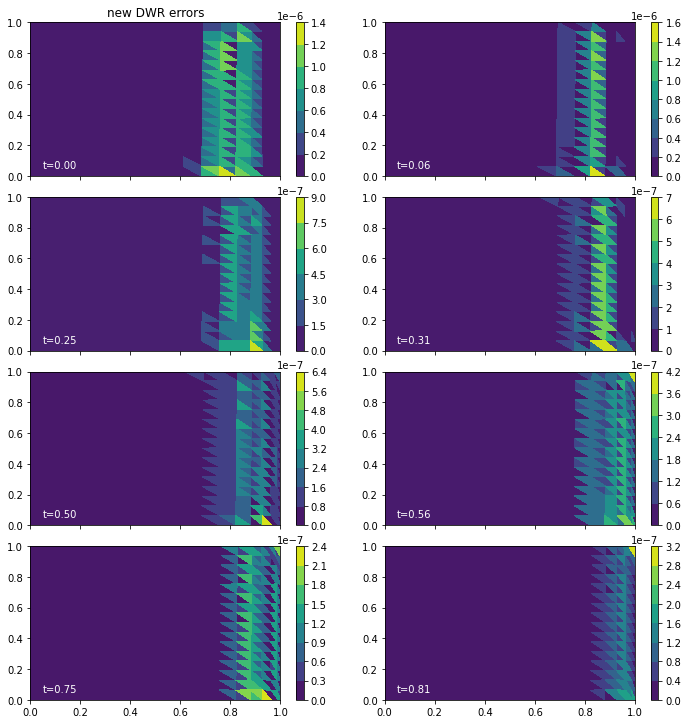

In [48]:
# def plot_indicators(indicators, time_partition, **kwargs):
#     """
#     Plot a sequence of snapshots associated with
#     ``indicators`` and :class:`TimePartition`
#     ``time_partition``.

#     Any keyword arguments are passed to ``tricontourf``.

#     :arg indicators: list of list of indicators,
#         indexed by mesh sequence index, then timestep
#     :arg time_partition: the :class:`TimePartition`
#         object used to solve the problem
#     """
#     P = time_partition
#     rows = P.exports_per_subinterval[0] - 1
#     cols = P.num_subintervals
#     steady = rows == cols == 1
#     print(rows, cols)
#     figsize = kwargs.pop("figsize", (6 * cols, 24 // cols))
#     fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
#     tcs = []
#     for i, indi_step in enumerate(indicators):
#         ax = axes if steady else axes[0] if cols == 1 else axes[0, i]
#         ax.set_title(f"Mesh[{i}]")
#         tc = []
#         for j, indi in enumerate(indi_step):
#             ax = axes if steady else axes[j] if cols == 1 else axes[j, i]
#             # Element-wise norm for the indicators
#             tc.append(tricontourf(indi, axes=ax, **kwargs))
#             if not steady:
#                 time = i * P.end_time/cols + j * P.timesteps_per_export[i] * P.timesteps[i]
#                 ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="white")
#         tcs.append(tc)
#     plt.tight_layout()
#     return fig, axes, tcs

figsize = (10, 10)
fig, axs, tcs = plot_indicators(indicators, time_partition, figsize=figsize)
print(len(axs), len(tcs), len(tcs[0]))
for i in range(len(axs)):
    for j in range(len(axs[i])):
        fig.colorbar(tcs[i][j], ax=axs[i, j])
axs[0, 0].set_title("new DWR errors")

4 2


Text(0.5, 1.0, 'new Log DWR Errors')

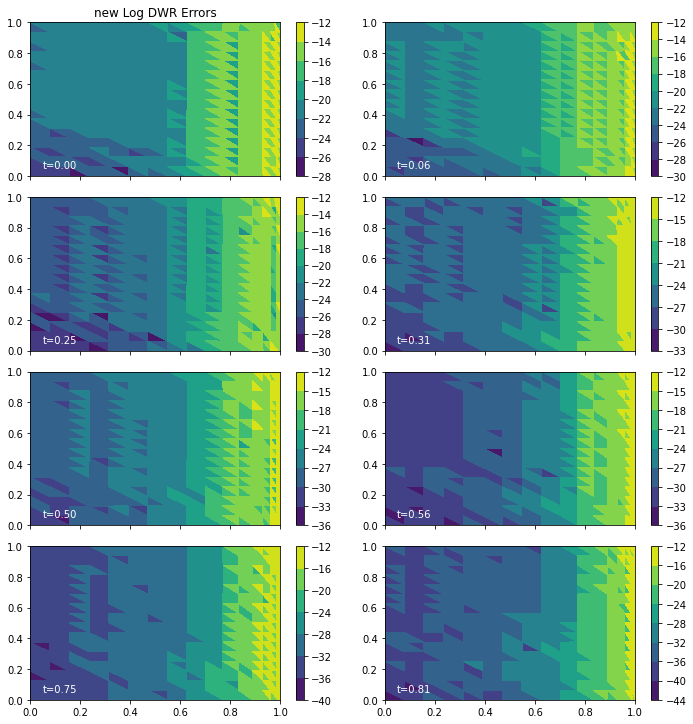

In [34]:
log_indicators = [ [Function(P0, val=np.log(indicators[0][i].dat.data)) for i in range(len(indicators[0]))]]
fig, axs, tcs = plot_indicators(log_indicators, time_partition, figsize=figsize)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        fig.colorbar(tcs[i][j], ax=axs[i, j])
axs[0][0].set_title("new Log DWR Errors")